In [1]:
from utils.data import Dataset
from utils.conllu import read_conllu_dataset
import numpy as np

In [2]:
dataset = Dataset()

train_sentences = read_conllu_dataset("data/ro_rrt-ud-train.conllu")
test_sentences = read_conllu_dataset("data/ro_rrt-ud-test.conllu")

# Fit on training data
X_train, y_train = dataset.fit(train_sentences, mode="chars")

# Encode test data (fixed shape)
X_test, y_test = dataset.encode(test_sentences)

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8043, 163, 55), (8043, 163, 17), (729, 163, 55), (729, 163, 17))

In [4]:
import tensorflow as tf

In [5]:
_, seq_len, char_feat_len = X_train.shape
output_dim = y_train.shape[-1]

In [6]:
sample_weight = np.where(np.argmax(y_train, axis=-1) != 0, 1.0, 0.0)

In [7]:
input_layer = tf.keras.layers.Input(shape=(seq_len, char_feat_len))
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(input_layer)
output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_dim, activation='softmax'))(lstm)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', weighted_metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 163, 55)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 163, 256)       │       188,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 163, 17)        │         4,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,785 (753.07 KB)

 Trainable params: 192,785 (753.07 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    sample_weight = sample_weight
)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.4310 - loss: 0.2563 - val_accuracy: 0.6280 - val_loss: 0.1717
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6226 - loss: 0.1600 - val_accuracy: 0.6803 - val_loss: 0.1453
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6784 - loss: 0.1348 - val_accuracy: 0.7104 - val_loss: 0.1301
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7195 - loss: 0.1189 - val_accuracy: 0.7222 - val_loss: 0.1221
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7417 - loss: 0.1093 - val_accuracy: 0.7447 - val_loss: 0.1126
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7617 - loss: 0.1016 - val_accuracy: 0.7599 - val_loss: 0.1066
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7798 - loss: 0.0950 - val_accuracy: 0.7700 - val_loss: 0.1016
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7924 - loss: 0.0881 - val_accu

In [9]:
import matplotlib.pyplot as plt

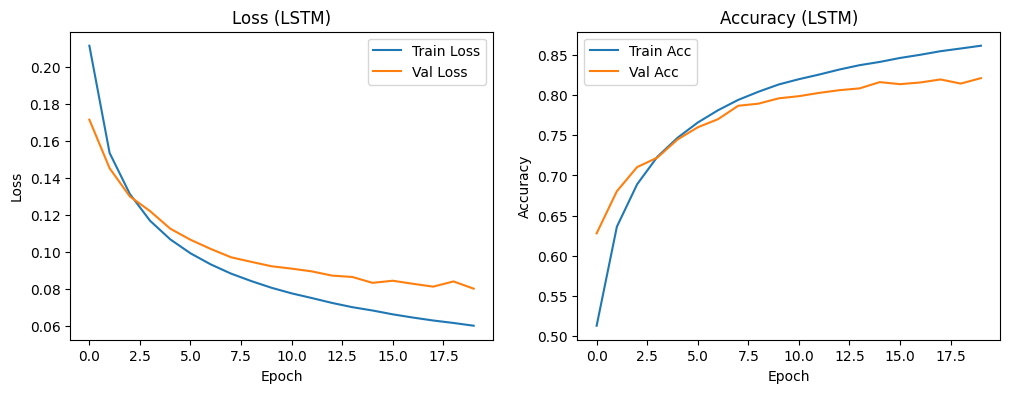

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
model.save('pos_lstm_model.keras')

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, sample_weight=np.where(np.argmax(y_test, axis=-1) != 0, 1.0, 0.0))
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8251 - loss: 0.0716

Test Loss: 0.0728 | Test Accuracy: 0.8246


In [13]:
import numpy as np
y_pred = model.predict(X_test)
y_pred_ids = np.argmax(y_pred, axis=-1)
y_true_ids = np.argmax(y_test, axis=-1)

# Reverse label index
idx2label = {i: l for l, i in dataset.label2id.items()}

# Show sample predictions
for i in range(3):
    print(f"\n--- Sentence {i+1} ---")
    for j in range(seq_len):
        word_vec = X_test[i, j]
        if np.all(word_vec == 0): continue  # padding

        pred_label = idx2label.get(y_pred_ids[i, j]-1, "UNK")
        true_label = idx2label.get(y_true_ids[i, j]-1, "UNK")
        print(f"{j:2}: Pred: {pred_label:6} | True: {true_label}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step

--- Sentence 1 ---
 0: Pred: INTJ   | True: INTJ
 1: Pred: PART   | True: PART
 2: Pred: SCONJ  | True: SCONJ
 3: Pred: INTJ   | True: SCONJ
 4: Pred: ADP    | True: ADP
 5: Pred: PART   | True: PART
 6: Pred: ADV    | True: ADV
 7: Pred: SCONJ  | True: SCONJ
 8: Pred: ADJ    | True: ADJ
 9: Pred: INTJ   | True: INTJ
10: Pred: PROPN  | True: PROPN

--- Sentence 2 ---
 0: Pred: ADJ    | True: ADJ
 1: Pred: SCONJ  | True: INTJ
 2: Pred: PART   | True: PART
 3: Pred: INTJ   | True: SCONJ
 4: Pred: CCONJ  | True: CCONJ
 5: Pred: INTJ   | True: INTJ
 6: Pred: ADJ    | True: ADJ
 7: Pred: INTJ   | True: INTJ
 8: Pred: ADJ    | True: <PAD>
 9: Pred: ADJ    | True: ADJ
10: Pred: SCONJ  | True: INTJ
11: Pred: AUX    | True: AUX
12: Pred: CCONJ  | True: CCONJ
13: Pred: INTJ   | True: INTJ
14: Pred: PART   | True: PART
15: Pred: PART   | True: PART
16: Pred: SCONJ  | True: SCONJ
17: Pred: INTJ   | True: ADJ
18: Pred: CCONJ  | True: PART
19: Pred: PROPN  |

In [14]:
np.argmax(y_test, axis=-1)[0]

array([ 8, 11, 15, 15,  3, 11,  4, 15,  2,  8, 13,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [15]:
y_true_flat = y_true_ids.reshape((-1,))
y_pred_flat = y_pred_ids.reshape((-1,))
mask = (y_true_flat != 0)
y_true_flat = y_true_flat[mask]
y_pred_flat = y_pred_flat[mask]

np.max(y_true_flat), np.min(y_true_flat), np.max(y_pred_flat), np.min(y_pred_flat)

np.sum(y_true_flat==7), np.sum(y_pred_flat==7)


(np.int64(6), np.int64(0))

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00         0
         ADJ       0.65      0.50      0.57      1172
         ADP       0.95      0.98      0.96      2333
         ADV       0.67      0.64      0.65       650
         AUX       0.89      0.90      0.89       618
       CCONJ       0.95      0.96      0.95       471
         DET       0.84      0.81      0.82       898
        INTJ       0.00      0.00      0.00         6
        NOUN       0.74      0.85      0.79      4042
         NUM       0.86      0.75      0.80       456
        PART       0.94      0.90      0.92       358
        PRON       0.81      0.74      0.77       862
       PROPN       0.72      0.65      0.68       455
       PUNCT       0.97      1.00      0.98      2083
       SCONJ       0.73      0.77      0.75       154
        VERB       0.79      0.70      0.74      1749
           X       1.00      0.18      0.30        17

   

d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

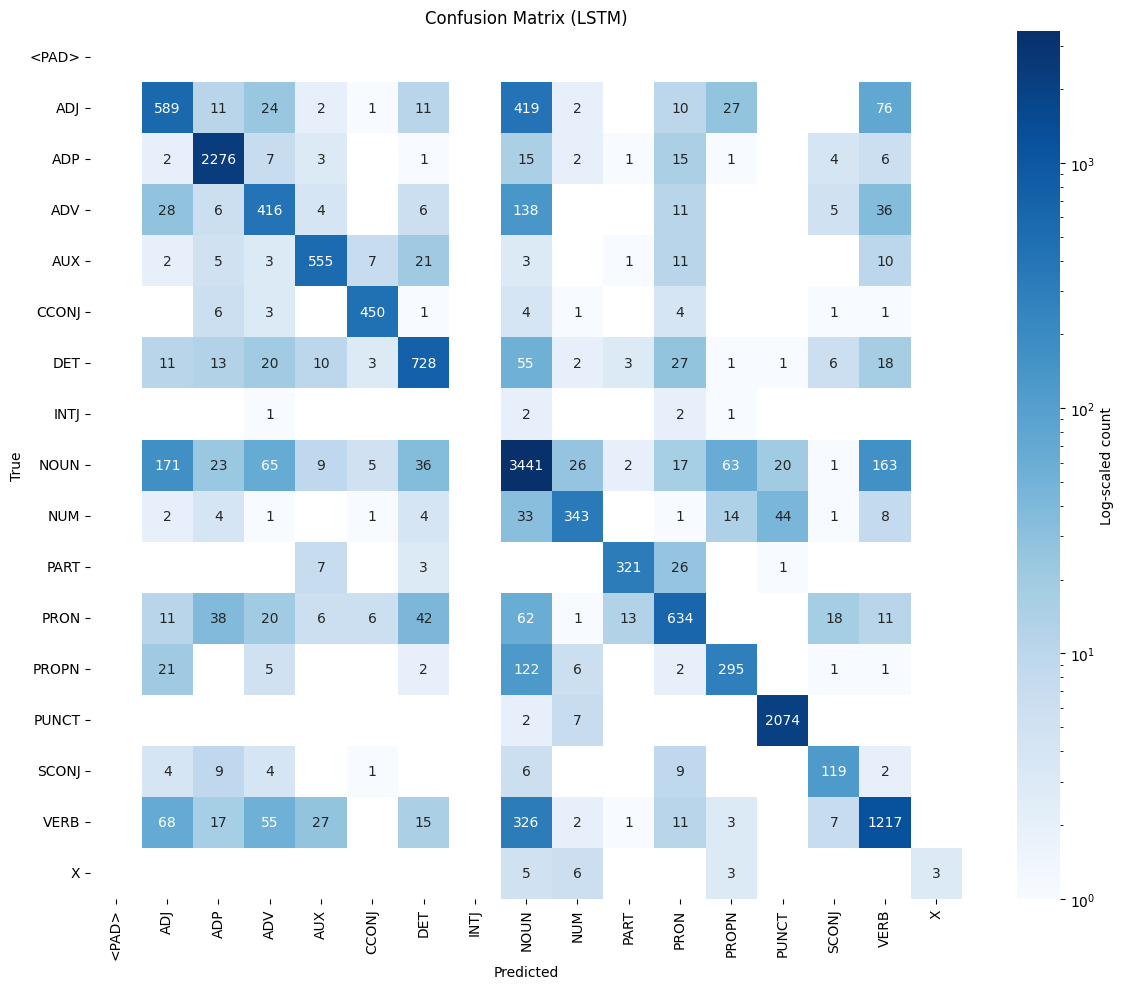

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.colors import LogNorm

# Compute confusion matrix
labels = dataset.labels
label_ids = list(range(len(labels)))

print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, labels=label_ids, target_names=labels))

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=label_ids)

# Plot with log scale
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', norm=LogNorm(vmin=1, vmax=cm.max()),
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Log-scaled count'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (LSTM)")
plt.tight_layout()
plt.show()
